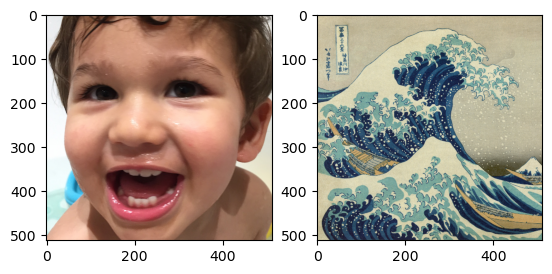

In [39]:
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

# print(os.getcwd())
# os.chdir('/Users/dengyi/Desktop/program_instances/pytorch_practice')
content_path = 'content.png'
style_path = 'style.png'
plt.subplot(121)
figure = cv2.imread(content_path)
plt.imshow(cv2.cvtColor(figure, cv2.COLOR_BGR2RGB))

plt.subplot(122)
figure = cv2.imread(style_path)
plt.imshow(cv2.cvtColor(figure, cv2.COLOR_BGR2RGB))

In [40]:
import PIL.Image as Image
import torchvision.transforms as transforms
img_size = 512

def load_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((img_size, img_size))
    img = transforms.ToTensor()(img)
    img = img.unsqueeze(0)
    return img

In [41]:
import torch
from torch.autograd import Variable

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
style_img = load_image(style_path)
style_img = Variable(style_img).to(device)
content_img = load_image(content_path)
content_img = Variable(content_img).to(device)
print(style_img.size(), content_img.size())

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


#### 算法原理
输入G，内容C，风格S，内容损失D_C，风格损失D_S。内容损失函数为交叉熵损失，风格损失函数为

In [42]:
import torch.nn as nn

class Content_Loss(nn.Module):
    def __init__(self, target, weight):
        super(Content_Loss, self).__init__()
        self.weight = weight
        self.target = target.detach() * self.weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input*self.weight, self.target)
        out = input.clone()
        return out

    def backward(self, retain_variables=True):
        self.loss.backward(retain_graph=retain_variables)
        return self.loss

In [43]:
cl = Content_Loss(content_img, 1)
rand_img = torch.randn(content_img.size(), device=device)
cl.forward(rand_img)
print(cl.loss)

tensor(1.3053)


In [44]:
class Gram(nn.Module):
    def __init__(self):
        super(Gram, self).__init__()

    def forward(self, input):
        a, b, c, d = input.size()
        feature = input.view(a*b, c*d)
        gram = torch.mm(feature, feature.t())
        gram /= (a*b*c*d)
        return gram

gram = Gram()
gram

Gram()

In [45]:
target = gram(style_img)
target

tensor([[0.1355, 0.1371, 0.1185],
        [0.1371, 0.1413, 0.1237],
        [0.1185, 0.1237, 0.1102]])

In [46]:
class Style_Loss(nn.Module):
    def __init__(self, target, weight):
        super(Style_Loss, self).__init__()
        self.weight = weight
        self.target = target.detach() * self.weight
        self.gram = Gram()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        G = self.gram(input) * self.weight
        self.loss = self.criterion(G, self.target)
        out = input.clone()
        return out
    
    def backward(self, retain_variables=True):
        self.loss.backward(retain_graph=retain_variables)
        return self.loss

In [47]:
sl = Style_Loss(target, 1000)
rand_img = torch.randn(style_img.data.size(), device=device)
sl.forward(rand_img)
sl.loss

tensor(24771.2402)

#### 下载与训练模型

In [48]:
import torchvision.models as models
# torch.utils.model_zoo.load_url("https://labfile.oss.aliyuncs.com/courses/861/vgg19_pre.zip")

In [49]:
vgg = models.vgg19(pretrained=True).features
# vgg = models.vgg19(weights=VGG19_Weights.DEFAULT).features
vgg = vgg.to(device)
vgg

/Users/dengyi/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dengyi/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [50]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
model = nn.Sequential()
model = model.to(device)

def get_style_model_and_loss(style_img, content_img, cnn=vgg, style_weight=1000, content_weight=1,
                             content_layers=content_layers_default, style_layers=style_layers_default):
    content_loss_list = []
    style_loss_list = []

    gram = Gram()
    gram = gram.to(device)

    i = 1
    for layer in cnn:
        if isinstance(layer, nn.Conv2d):
            name = 'conv_' + str(i)
            model.add_module(name, layer)

            if name in content_layers_default:
                target = model(content_img)
                content_loss = Content_Loss(target, content_weight)
                model.add_module('content_loss_' + str(i), content_loss)
                content_loss_list.append(content_loss)
            
            if name in style_layers_default:
                target = model(style_img)
                target = gram(target)
                style_loss = Style_Loss(target, style_weight)
                model.add_module('style_loss' + str(i), style_loss)
                style_loss_list.append(style_loss)

            i += 1

        if isinstance(layer, nn.MaxPool1d):
            name = 'pool_' + str(i)
            model.add_module(name, layer)
    
        if isinstance(layer, nn.ReLU):
            name = 'relu' + str(i)
            model.add_module(name, layer)

    return model, style_loss_list, content_loss_list

In [51]:
model, style_loss_list, content_loss_list = get_style_model_and_loss(
    style_img, content_img
)
model

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss1): Style_Loss(
    (gram): Gram()
    (criterion): MSELoss()
  )
  (relu2): ReLU(inplace=True)
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss2): Style_Loss(
    (gram): Gram()
    (criterion): MSELoss()
  )
  (relu3): ReLU(inplace=True)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss3): Style_Loss(
    (gram): Gram()
    (criterion): MSELoss()
  )
  (relu4): ReLU(inplace=True)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): Content_Loss(
    (criterion): MSELoss()
  )
  (style_loss4): Style_Loss(
    (gram): Gram()
    (criterion): MSELoss()
  )
  (relu5): ReLU(inplace=True)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss5): Style_Loss(
    (gram): Gram()
    (criterion): MSELoss()
  )
  (relu6): ReL

In [52]:
import torch.optim as optim

def get_input_param_optimer(input_img):
    input_param = nn.Parameter(input_img.data)
    optimzer = optim.LBFGS([input_param])
    return input_param, optimzer

get_input_param_optimer(rand_img)

(Parameter containing:
 tensor([[[[ 0.4676,  1.3344,  1.4158,  ..., -1.7977, -0.4844, -0.2917],
           [-1.0016, -1.4350,  0.6974,  ..., -1.4874,  0.2840,  1.1473],
           [-0.9275,  1.0162,  1.9065,  ...,  0.3534, -0.7622, -0.3600],
           ...,
           [-0.2562, -0.3438,  1.6188,  ..., -1.1780, -0.0324,  0.1844],
           [ 0.5725, -1.0309,  0.1748,  ..., -0.1577,  0.6842, -0.9518],
           [ 0.4551, -0.3127, -1.5817,  ..., -0.5616, -1.6187, -0.7833]],
 
          [[-0.5026, -0.7657,  0.2387,  ..., -0.5467, -0.5816, -0.1666],
           [-0.2559,  2.1230,  0.4421,  ...,  1.3751,  1.0218,  1.3410],
           [ 0.0547, -0.7677,  1.9444,  ...,  1.4909,  1.5394,  0.0469],
           ...,
           [-0.4867, -0.1552, -1.0346,  ...,  0.3150, -0.4291, -1.3306],
           [ 0.1668,  0.8964, -0.1571,  ...,  0.1691,  0.4132,  0.1166],
           [-0.0626,  0.9807, -0.8704,  ..., -0.4714, -0.2020,  0.9970]],
 
          [[ 0.1869, -0.9771, -1.6189,  ..., -1.5532, -2.2946, 

In [53]:
def run_style_transfer(content_img, style_img, input_img, num_epoches):
    print('Building the style transfer model...')
    input_param, optimizer = get_input_param_optimer(input_img)
    print('Optimizing...')
    epoch = [0]
    while epoch[0] < num_epoches:
        print("epoch[0]: ", epoch[0])
        def closure():
            input_param.data.clamp_(0, 1)
            model(input_param)
            style_score = 0
            content_score = 0
            optimizer.zero_grad()
            for sl in style_loss_list:
                style_score += sl.backward()
            for cl in content_loss_list:
                content_score += cl.backward()

            epoch[0] += 1
            if epoch[0] % 1 == 0:
                print('run {}/{}'.format(epoch[0], num_epoches))
                print('Style Loss: {:.4f} Content Loss: {:.4f}\n'.format(
                    style_score.data.item(), content_score.data.item()
                ))
            
            return style_score + content_score

        optimizer.step(closure)

    return input_param.data

In [54]:
input_img = content_img.clone()
out = run_style_transfer(content_img, style_img, input_img, num_epoches=2)
new_pic = transforms.ToPILImage()(out.cpu().squeeze(0))
print('训练完成')

Building the style transfer model...
Optimizing...
epoch[0]:  0
run 1/2
Style Loss: 122.3126 Content Loss: 0.0000

run 2/2
Style Loss: 122.3088 Content Loss: 0.0000

run 3/2
Style Loss: 116.8737 Content Loss: 0.0117



[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [ ]:
plt.show(new_pic)